In [1]:
%matplotlib widget
# %matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.optimize import curve_fit


from qick import *
from qick.helpers import gauss

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq
import Pyro4.util

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})
mpl.rcParams['figure.dpi'] = 150

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linestyle_cycle=['solid', 'dashed', 'dotted', 'dashdot']
marker_cycle = ['o', '*', 's', '^']

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


# Load experiments

In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

### Set save data

In [4]:
save_data = False

In [5]:
def prev_data(expt_path, filename=None):
    """Reopen saved data"""
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [6]:
data_path = 'S:\\QRAM\\qram_4QR2\\'
expt_path = os.path.join(data_path, 'data', 'data_241025')
print('Data will be stored in', expt_path)

Data will be stored in S:\QRAM\qram_4QR2\data\data_241025


In [7]:
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


# Load config

In [212]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [9]:
im = InstrumentManager(ns_address='10.108.30.75') # Spilker Fermium
print(list(im))

['Pyro.NameServer', 'Qick_QRAM']


In [10]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)

QICK running on ZCU216, software version 0.2.272

Firmware configuration (built Sat Oct  5 10:21:47 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MH

## Parameter

In [175]:
qubit_i = 1

# Rabi versus amplitude 

We first want to know the relationship between the gain and rabi drive strength

In [176]:
gain_start = 100 
gain_stop = 1000
gain_pts = 5
gain_vec = np.linspace(gain_start, gain_stop, gain_pts)

reps = 1
rounds = 100 

t_start = 0.1
t_stop = 0.5 # us
t_pts = 300
t_step = (t_stop - t_start) / t_pts
print(f'Time step is {t_step} us')
t_step = soc.cycles2us(soc.us2cycles(t_step))
print(f'Time step is {t_step} cycles')

rabi_freq_vec = np.zeros(gain_pts)
rabi_freq_vec_err = np.zeros(gain_pts)

save_data = True

Time step is 0.0013333333333333335 us
Time step is 0.0023251488095238095 cycles


In [177]:

RabiFreqExpt = Experiment(
                        path=expt_path,
                        prefix=f"rabi_freq_{qubit_i}",
                        config_file=config_path)

RabiFreqExpt.data = dict(amps=[], times=[], rabi_freq = [], gain_pts=[])
RabiFreqExpt.data['gain_pts'] = gain_vec

time_vec = []
amps_vec = []


for idx_g, g in enumerate(gain_vec):
    print(f"Gain {g} ({idx_g+1}/{len(gain_vec)})")

    lengthrabi = meas.LengthRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"length_rabi_qubit{qubit_i}",
        config_file=config_path,
    )
    lengthrabi.cfg = AttrDict(deepcopy(yaml_cfg))
    
    lengthrabi.cfg.device.qubit.pulses.pi_ge.half_gain[qubit_i*5] = int(g)

    lengthrabi.cfg.expt = dict(
        start=t_start, # pulse length (sigma) [us]
        step=t_step, # [us]
        expts=t_pts,
        reps=reps*rounds,
        pulse_type='gauss',
        checkEF=False, 
        qTest=qubit_i,
        qZZ=None,
    )

    import Pyro4.util
    try:
        lengthrabi.go(analyze=False, display=False, progress=True, save=False)
        
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
        

    amps = lengthrabi.data['amps']
    time = lengthrabi.data['xpts']
    # compute FFT
    amp_fft = fft(amps)
    freq = fftfreq(len(amps), time[1] - time[0])
    
    # find the peak
    idx = np.argmax(np.abs(amp_fft[1:])) + 1
    freq_peak = freq[idx]
    

    rabi_freq_vec[idx_g] = freq_peak/2

    
    if save_data:
        time_vec.append(time)
        amps_vec.append(amps)
        
        
    


Gain 100.0 (1/5)
Running length rabi on Q1 


  0%|          | 0/300 [00:00<?, ?it/s]

Gain 325.0 (2/5)
Running length rabi on Q1 


  0%|          | 0/300 [00:00<?, ?it/s]

Gain 550.0 (3/5)
Running length rabi on Q1 


  0%|          | 0/300 [00:00<?, ?it/s]

Gain 775.0 (4/5)
Running length rabi on Q1 


  0%|          | 0/300 [00:00<?, ?it/s]

Gain 1000.0 (5/5)
Running length rabi on Q1 


  0%|          | 0/300 [00:00<?, ?it/s]

In [178]:
# fit with a linear function

def linear(x, a, b):
    return a*x + b

popt, pcov = curve_fit(linear, gain_vec, rabi_freq_vec)

a = popt[0]
a_err = np.sqrt(pcov[0,0])
b = popt[1]
b_err = np.sqrt(pcov[1,1])


if save_data:
    RabiFreqExpt.data['times'] = time_vec
    RabiFreqExpt.data['amps'] = amps_vec
    # divide by 2 to get the Rabi frequency ( given we apply two pi/2 actually)
    RabiFreqExpt.data['rabi_freq'] = rabi_freq_vec
    RabiFreqExpt.data['fit'] = [a, b]
    RabiFreqExpt.data['fit_err'] = [a_err, b_err]
    RabiFreqExpt.save_data()

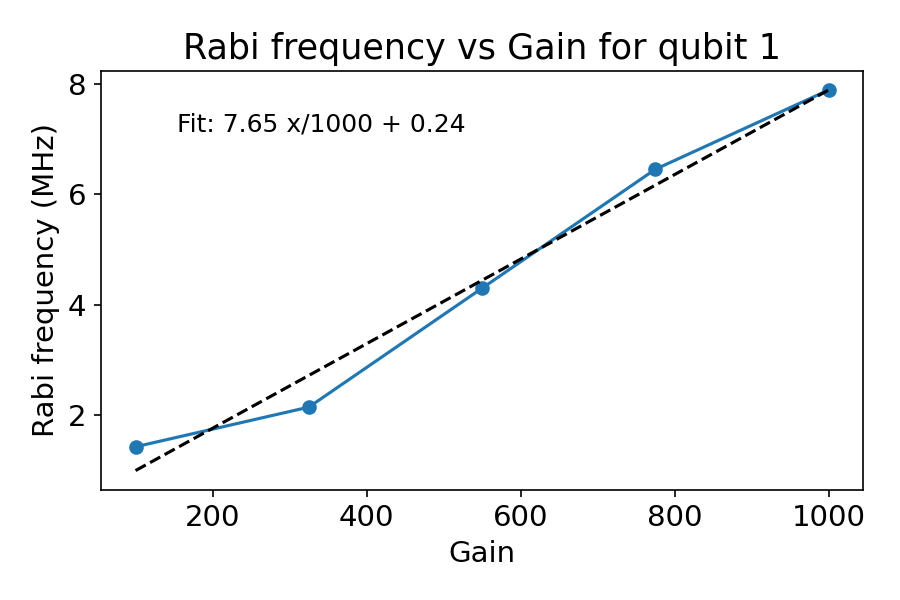

In [179]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(gain_vec, rabi_freq_vec, 'o-')
ax.plot(gain_vec, linear(gain_vec, *popt), '--', color='black')

text = f"Fit: {a*1000:.2f} x/1000 + {b:.2f}\n"
ax.text(0.1, 0.9, text, transform=ax.transAxes, fontsize=12, verticalalignment='top')

ax.set_xlabel('Gain')
ax.set_ylabel('Rabi frequency (MHz)')
ax.set_title(f'Rabi frequency vs Gain for qubit {qubit_i}')
fig.tight_layout()

In [180]:
filename = yaml_cfg.device.qubit.pulses.pihalf_ge_robust.filename[qubit_i]
path = os.path.join('S:\QRAM\qram_4QR2\optctrl_pulses', f"{filename}.npz")
nb_qb = 4


# open the file
scaling = 1

with np.load(path) as data:
    times = data['times']*scaling
    I = []
    Q = []
    for i in range(nb_qb):
        if 'I_'+str(i) in data:
            I.append(data['I_'+str(i)]/1e6/scaling)
            Q.append(data['Q_'+str(i)]/1e6/scaling)
        else:
            I.append(np.zeros(times.shape))
            Q.append(np.zeros(times.shape))

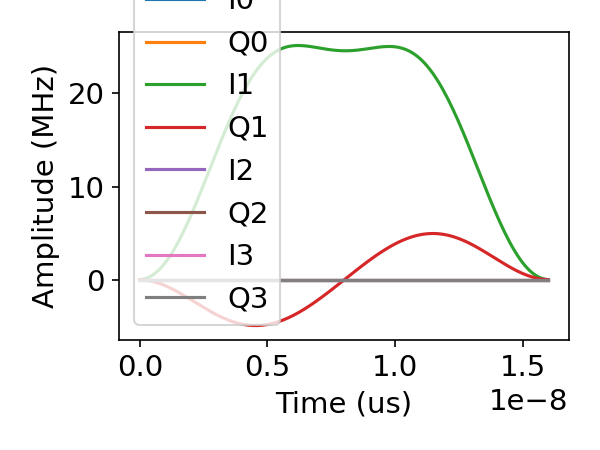

In [181]:
fig, ax = plt.subplots(figsize=(4,3))

for i in range(len(I)):
    ax.plot(times, I[i], label=f'I{i}')
    ax.plot(times, Q[i], label=f'Q{i}')
    
ax.set_xlabel('Time (us)')
ax.set_ylabel('Amplitude (MHz)')

ax.legend()
fig.tight_layout()
    

In [182]:
# for all qubit take the maximum of the I and Q

gain = np.zeros(len(I), dtype=int)

for i in range(len(I)):
    amp_I = np.max(np.abs(I[i]))
    amp_Q = np.max(np.abs(Q[i]))
    amp_max = np.max([amp_I, amp_Q])
    if amp_max == 0:
        gain[i] = 0
    else:
        gain_max = (amp_max - b) / a
        # for some reason the gain we need to set is twice the value
        gain[i] = gain_max*2
        
        

In [183]:
gain

array([   0, 6515,    0,    0])

# First round of error amplification to get the gain right

In [184]:
gain_scale = np.linspace(0.7, 1.3, 11)

x_tab = []
p_tab = []

# qubit_i=0
# gain = [7580, 0, 0, 0]


for s in gain_scale:

    npulsecalib = meas.NPulseExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"NPulseExptQ{qubit_i}",
        config_file=config_path,
    )

    npulsecalib.cfg = AttrDict(deepcopy(yaml_cfg))
    npulsecalib.cfg.device.qubit.pulses.pihalf_ge_robust[f"gain_q{qubit_i}"][qubit_i] = gain[qubit_i]*s

    npulsecalib.cfg.expt = dict(
        start=3, # number gate repetitions
        step=10,
        expts=1,
        reps=100,
        loops=10,
        pulse_type='robust',
        checkEF=False, 
        qTest=qubit_i,
        qZZ=None,
        test_pi_half=True,
        error_amp=True,
        skip_first_pi2=True,
        post_process='scale',
        singleshot_reps=5000,
    )

    # print(npulsecalib.cfg)
    import Pyro4.util
    try:
        npulsecalib.acquire(progress=True, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
        
        
    data = npulsecalib.data
    
    p_vec = data['avgi'][-1]
    x_vec = data['xpts'][-1]
    
    p_tab.append(p_vec)
    x_tab.append(x_vec)

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 59.62 	 angle (deg): -141.45228279020458 	 threshold ge: 289.64111747611366


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 62.980000000000004 	 angle (deg): -142.36499679231463 	 threshold ge: 291.9381287613039


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 60.28 	 angle (deg): -142.09598921161728 	 threshold ge: 293.1934179477654


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 61.36000000000001 	 angle (deg): -142.17189912286514 	 threshold ge: 291.07294672400076


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 61.4 	 angle (deg): -142.7414939615927 	 threshold ge: 305.71461387563437


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 61.44614461446145 	 angle (deg): -143.0582882087979 	 threshold ge: 290.9063685250208


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 62.88 	 angle (deg): -141.81075630604255 	 threshold ge: 283.6726173195692


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 62.019999999999996 	 angle (deg): -144.963653252266 	 threshold ge: 260.8932145145914


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 58.28 	 angle (deg): -143.4258407819014 	 threshold ge: 293.04190494173054


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 63.22632263226322 	 angle (deg): -144.67831680828533 	 threshold ge: 273.9263912596191


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 60.06 	 angle (deg): -144.55767530893047 	 threshold ge: 271.86259036364737


  0%|          | 0/10 [00:00<?, ?it/s]

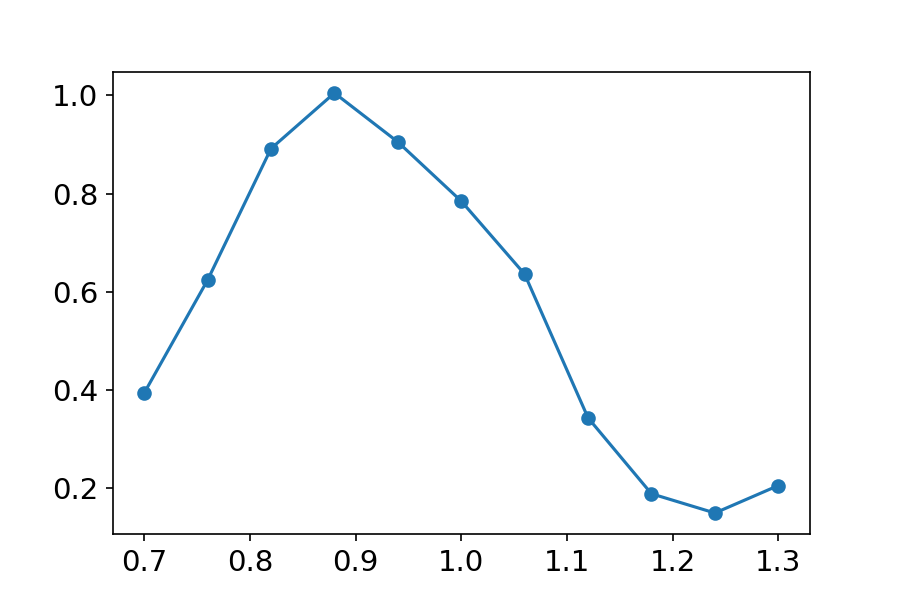

In [185]:
# fig, ax = plt.subplots(figsize=(6,4))   

# for i in range(len(p_tab)):
#     ax.plot(x_tab[i], p_tab[i], label=f'Gain {gain_scale[i]:.2f}')

# ax.set_xlabel('Number of pulses')
# ax.set_ylabel('Average intensity')
# ax.legend()

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(gain_scale, p_tab, 'o-')
    

In [186]:
gain_corr =  gain * 0.88
# save the new gain in the yaml file
yaml_cfg.device.qubit.pulses.pihalf_ge_robust[f"gain_q{qubit_i}"][qubit_i] = gain_corr[qubit_i]

# $\pi$-$\pi$ Exp

In [187]:
piminuspi = meas.PiMinusPiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"PiMinusPiExpt{qubit_i}",
    config_file=config_path,
)

span_f = 10
npts_f = 100

piminuspi.cfg = AttrDict(deepcopy(yaml_cfg))
# piminuspi.cfg.device.qubit.pulses.pihalf_ge_robust[f"gain_q{qubit_i}"][qubit_i] = gain_corr[qubit_i]

piminuspi.cfg.expt = dict(
    start_N=0, # number gate repetitions
    step_N=1,
    expts_N=10,
    start_f=piminuspi.cfg.device.qubit.f_ge_robust[qubit_i*4 + qubit_i]-span_f/2,
    step_f=span_f/npts_f,
    expts_f=npts_f+1,
    reps=int(0.75*reps*rounds),
    loops=1,
    pulse_type='robust',
    test_pi_half=True, 
    checkEF=False,
    qTest=qubit_i,
    qZZ=None,
    post_process='threshold',
    singleshot_reps=15000,
)

# print(piminuspi.cfg)
import Pyro4.util
try:
    piminuspi.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 61.94666666666667 	 angle (deg): -143.60950352479148 	 threshold ge: 265.5889550414371


  0%|          | 0/10 [00:00<?, ?it/s]

Fit best freq 3452.1080153228827 which is 3.9677590963392504 away from old freq 3448.1402562265434


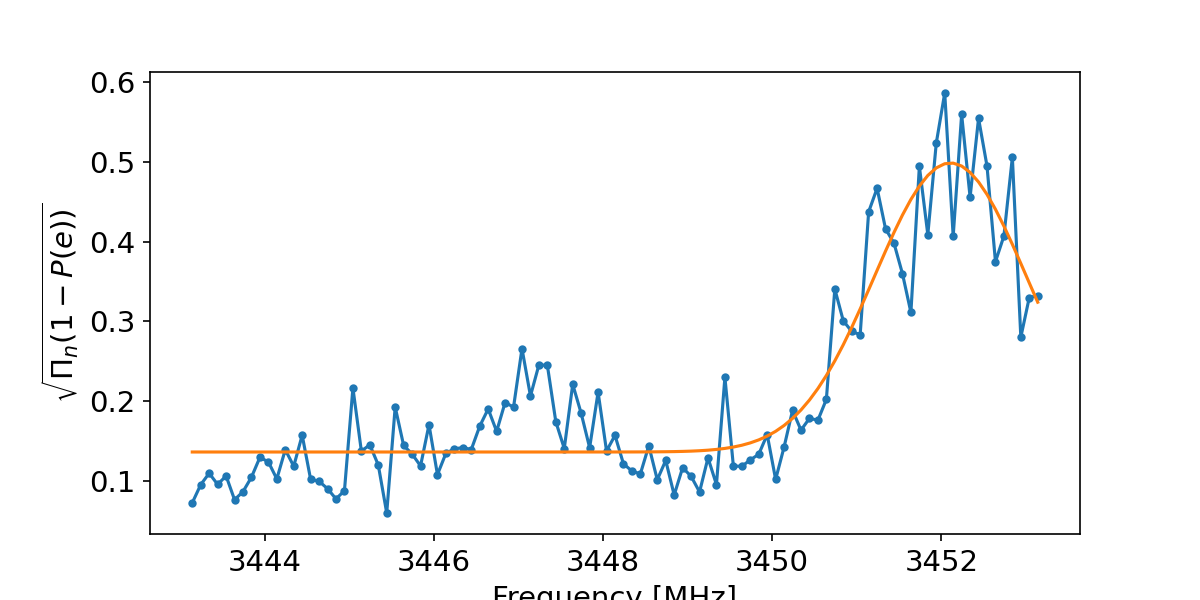

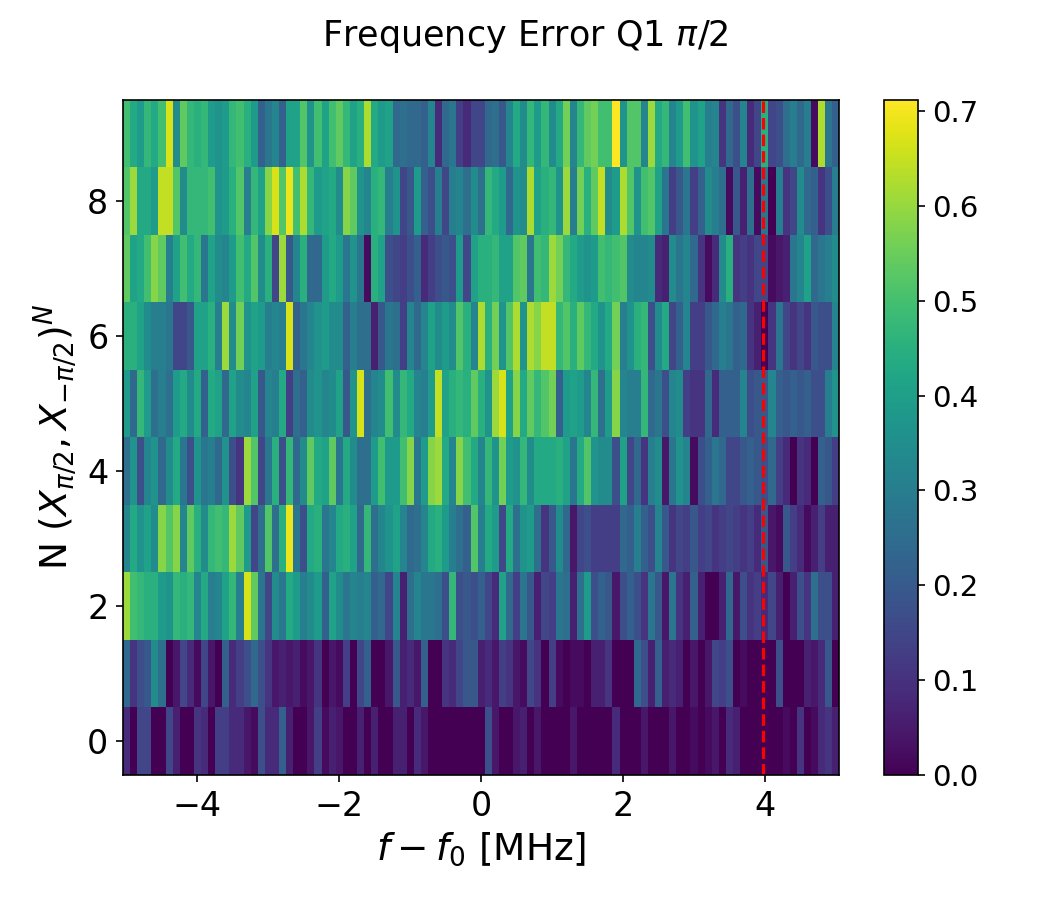

*New f_ge
 [[4114.49       4105.83890476 4110.9581533  4110.54640785]
 [3442.87557211 3452.10801532 3447.06031732 3446.49297928]
 [4762.76150413 4761.82356724 4763.94117763 4762.36981342]
 [4380.69860456 4379.60486812 4380.71783711 4384.25034226]]
*New f_ge flattened
[4114.49, 4105.838904759637, 4110.958153299016, 4110.546407850519, 3442.8755721075536, 3452.1080153228827, 3447.060317317807, 3446.4929792801067, 4762.761504132457, 4761.823567235975, 4763.941177625567, 4762.369813422167, 4380.698604555338, 4379.604868123916, 4380.717837106693, 4384.2503422597]


In [188]:
data = piminuspi.data
piminuspi.analyze(fit=True)
piminuspi.display(fit=True)

yaml_cfg.device.qubit.f_ge_robust = np.reshape(yaml_cfg.device.qubit.f_ge_robust, (4,4))
yaml_cfg.device.qubit.f_ge_robust[qubit_i, qubit_i] = data["best_freq"]
# results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
# print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i, qubit_i]}*')
# print(results_Qi)
print(f'*New f_ge\n', yaml_cfg.device.qubit.f_ge_robust)
yaml_cfg.device.qubit.f_ge_robust = yaml_cfg.device.qubit.f_ge_robust.flatten().tolist()
print(f'*New f_ge flattened\n{yaml_cfg.device.qubit.f_ge_robust}')



In [189]:
piminuspi.save_data()

Saving S:\QRAM\qram_4QR2\data\data_241025\00000_PiMinusPiExpt1.h5


'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00000_PiMinusPiExpt1.h5'

# Second round of error amplification

In [215]:
npulsecalib = meas.NPulseExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"NPulseExptQ{qubit_i}",
        config_file=config_path,
    )


# 


qubit_i = 0
npulsecalib.cfg = AttrDict(deepcopy(yaml_cfg))

# npulsecalib.cfg.device.qubit.pulses.pihalf_ge_robust[f"gain_q{qubit_i}"][qubit_i] = 5997.644279241582

npulsecalib.cfg.expt = dict(
    start=1, # number gate repetitions
    step=1,
    expts=10,
    reps=100,
    loops=10,
    pulse_type='robust',
    checkEF=False, 
    qTest=qubit_i,
    qZZ=1,
    test_pi_half=True,
    error_amp=True,
    skip_first_pi2 = False, 
    post_process='scale',
    singleshot_reps=1000,
)

# print(npulsecalib.cfg)
import Pyro4.util
try:
    npulsecalib.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (0)
ge fidelity (%): 77.7 	 angle (deg): 8.30789719247419 	 threshold ge: 496.90786567312387


  0%|          | 0/10 [00:00<?, ?it/s]

Setting up robust pulse for qubit 0, ZZ_qubit 1
freq_MHz: 4114.49, gain: 0
Setting up robust pulse for qubit 0, ZZ_qubit 1
freq_MHz: 4114.49, gain: 0
Setting up robust pulse for qubit 0, ZZ_qubit 1
freq_MHz: 4114.49, gain: 0
Setting up robust pulse for qubit 0, ZZ_qubit 1
freq_MHz: 4114.49, gain: 0
Setting up robust pulse for qubit 0, ZZ_qubit 1
freq_MHz: 4114.49, gain: 0
Setting up robust pulse for qubit 0, ZZ_qubit 1
freq_MHz: 4114.49, gain: 0
Setting up robust pulse for qubit 0, ZZ_qubit 1
freq_MHz: 4114.49, gain: 0
Setting up robust pulse for qubit 0, ZZ_qubit 1
freq_MHz: 4114.49, gain: 0
Setting up robust pulse for qubit 0, ZZ_qubit 1
freq_MHz: 4114.49, gain: 0
Setting up robust pulse for qubit 0, ZZ_qubit 1
freq_MHz: 4114.49, gain: 0
Setting up robust pulse for qubit 0, ZZ_qubit 1
freq_MHz: 4114.49, gain: 0
Setting up robust pulse for qubit 0, ZZ_qubit 1
freq_MHz: 4114.49, gain: 0
Setting up robust pulse for qubit 0, ZZ_qubit 1
freq_MHz: 4114.49, gain: 0
Setting up robust pulse f

KeyboardInterrupt: 

fitparams [None, 0.017453292519943295]
From amps: adjust amplitude to 7580 / 0.9443120437154968 = 8027.007651173947


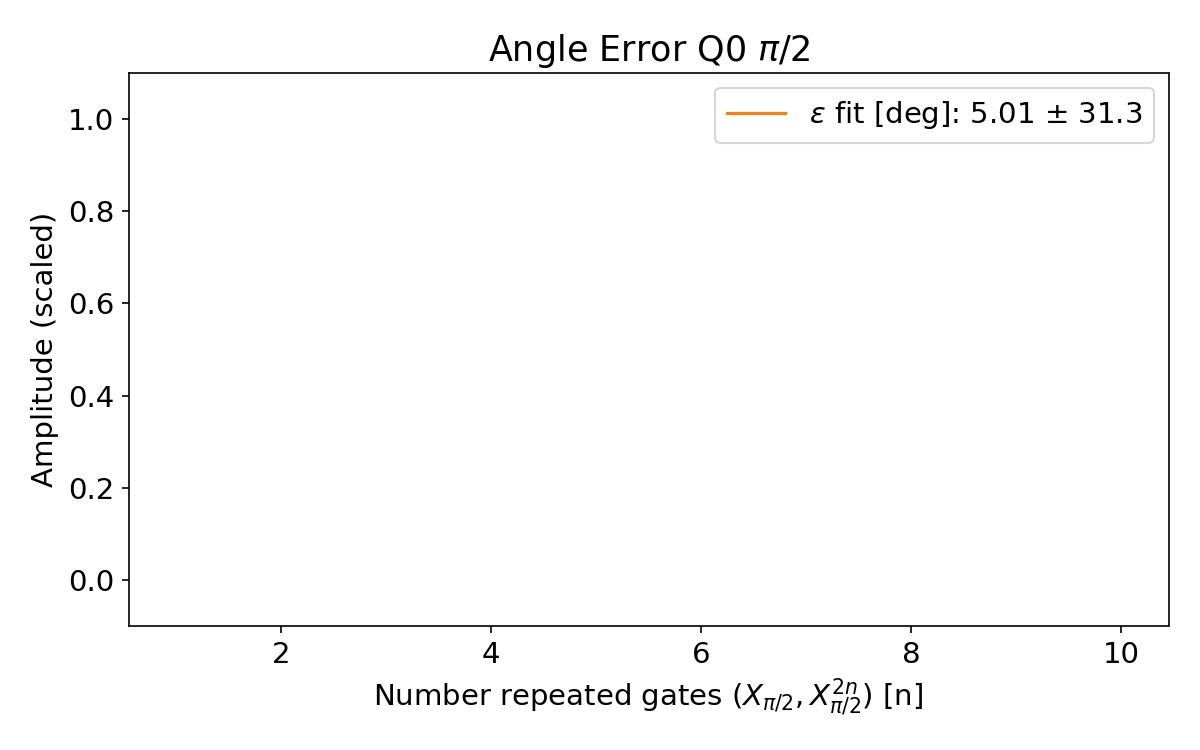

From avgi: adjust amplitude to 7580 / 0.9997534626311275 = 7581.869214087176

From avgq: adjust amplitude to 7580 / 0.9443400183935822 = 8026.769862929611


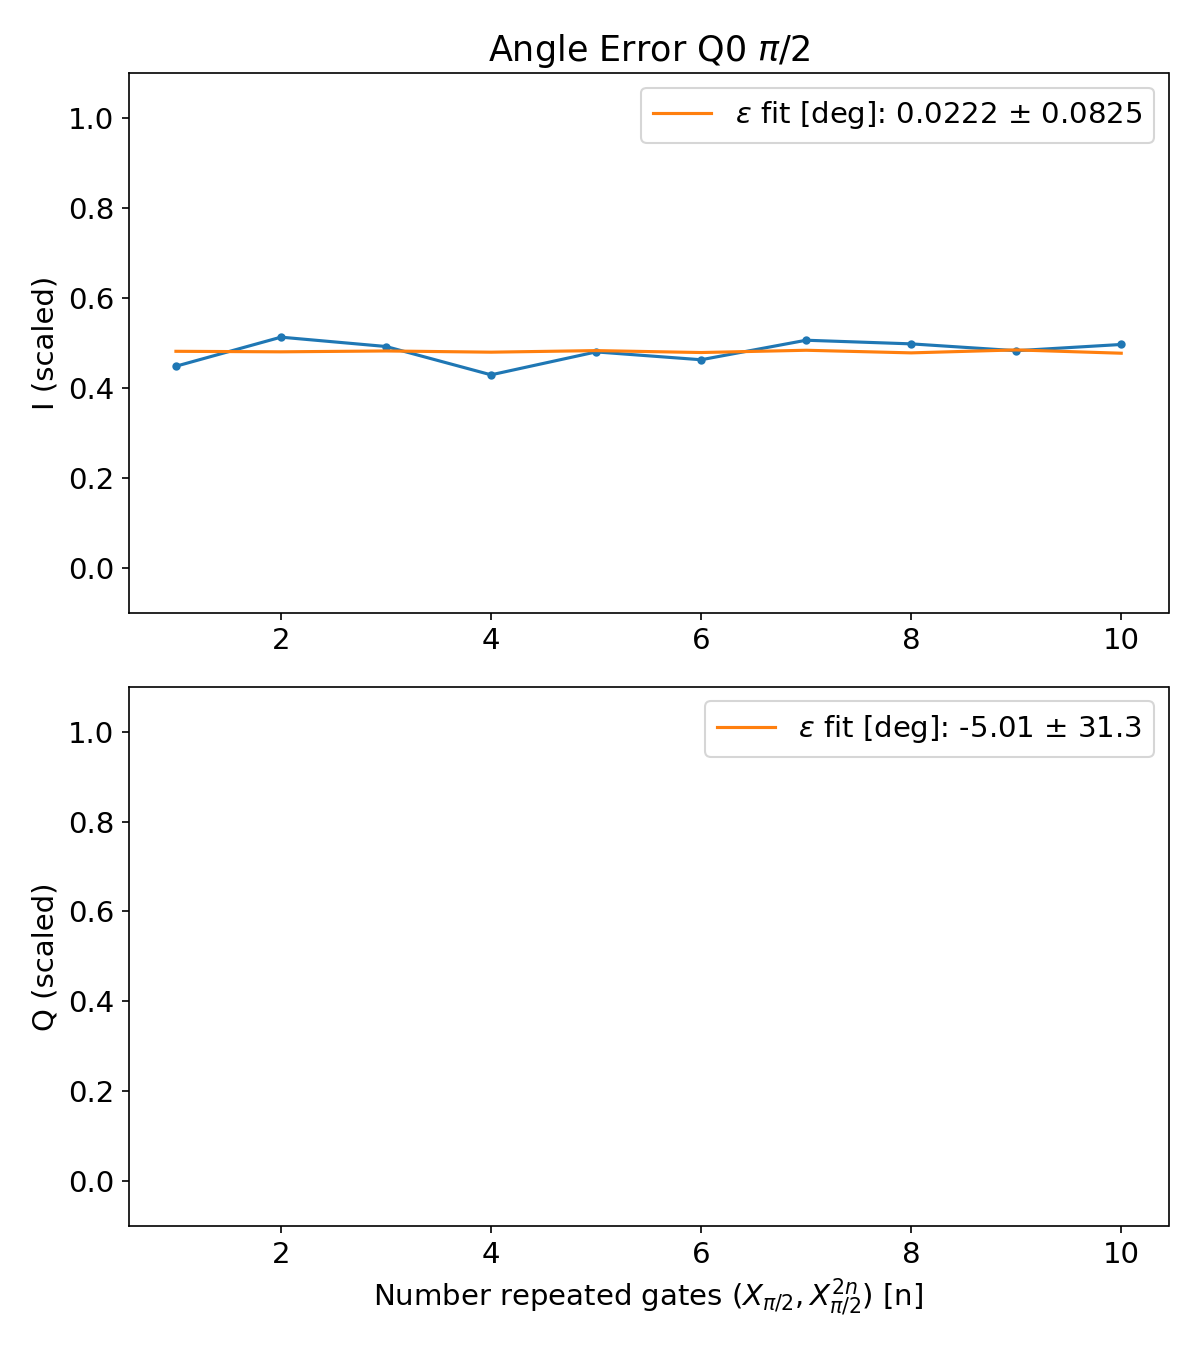

In [214]:
data = npulsecalib.data
npulsecalib.analyze(fit=True, scale=None)
npulsecalib.display(fit=True, scale=None)